# Demonstration of scNSBM on scRNA-seq data

This notebook demonstrate how to apply Nested Stochastic Block Model on scRNA-seq data. Here data are taken from the sc-mixology project, include 5 cell lines mixed at known proportions and anayzed on Chromium 10x platform

In [1]:
import scanpy as sc
import scnsbm 
import pandas as pd
%pylab
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import anndata

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Data import
import counts and metadata for 10x experiment with 5 cell lines, setup the `adata` object

In [2]:
tdata = pd.read_table("https://github.com/LuyiTian/sc_mixology/raw/master/data/csv/sc_10x_5cl.count.csv.gz", sep=",")
metadata = pd.read_table("https://github.com/LuyiTian/sc_mixology/raw/master/data/csv/sc_10x_5cl.metadata.csv.gz", sep=",")

Create a `adata` object. Keep in mind that data should be transposed. Also add annotations from metadata

In [3]:
adata = anndata.AnnData(tdata.T)

metadata_cols = ['cell_line', 'cell_line_demuxlet', 'demuxlet_cls']
adata.obs = metadata.loc[:, metadata_cols]
for c in metadata_cols:
    adata.obs.loc[:, c] = pd.Categorical(adata.obs.loc[:, c])

## Analysis with scanpy

Here we perform initial standard analysis step for `scanpy`. Refer to scanpy documentation for details.

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.05, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

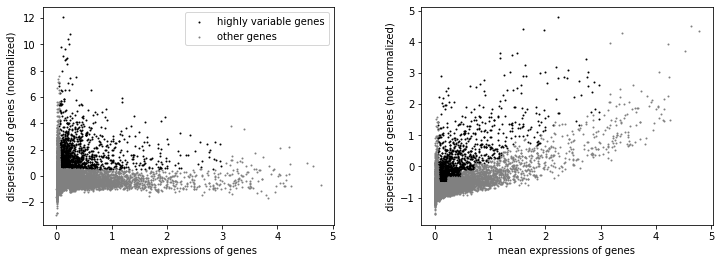

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [6]:
adata = adata[:, adata.var.highly_variable]

In [7]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

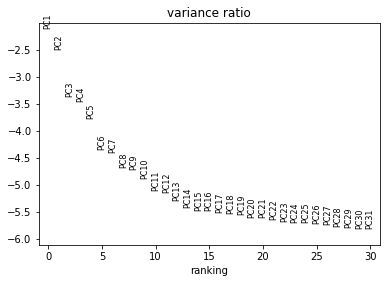

In [8]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=10)

In [10]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

Plot UMAP for clustered data. Here comes the first issue, that is at default resolution parameters there is overclustering. Of course, it is expected to have heterogeneity within cells, so all clusters may be legit. This is true also for any clustering approach.

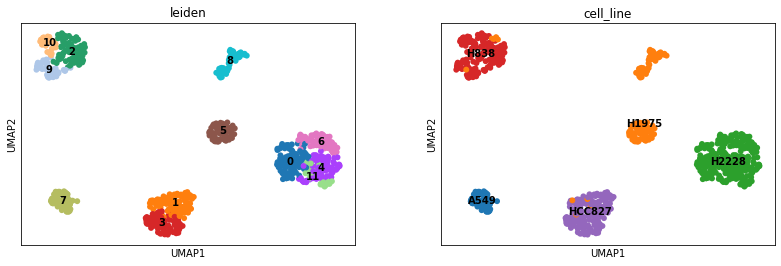

In [11]:
sc.pl.umap(adata, color=['leiden', 'cell_line'], legend_loc='on data')

Note that at different resolutions (from 0.01 to 1) there is no cluster in which H1979 are considered together. Not only, A549 and HCC827 are grouped together at low resolution, before H1979.

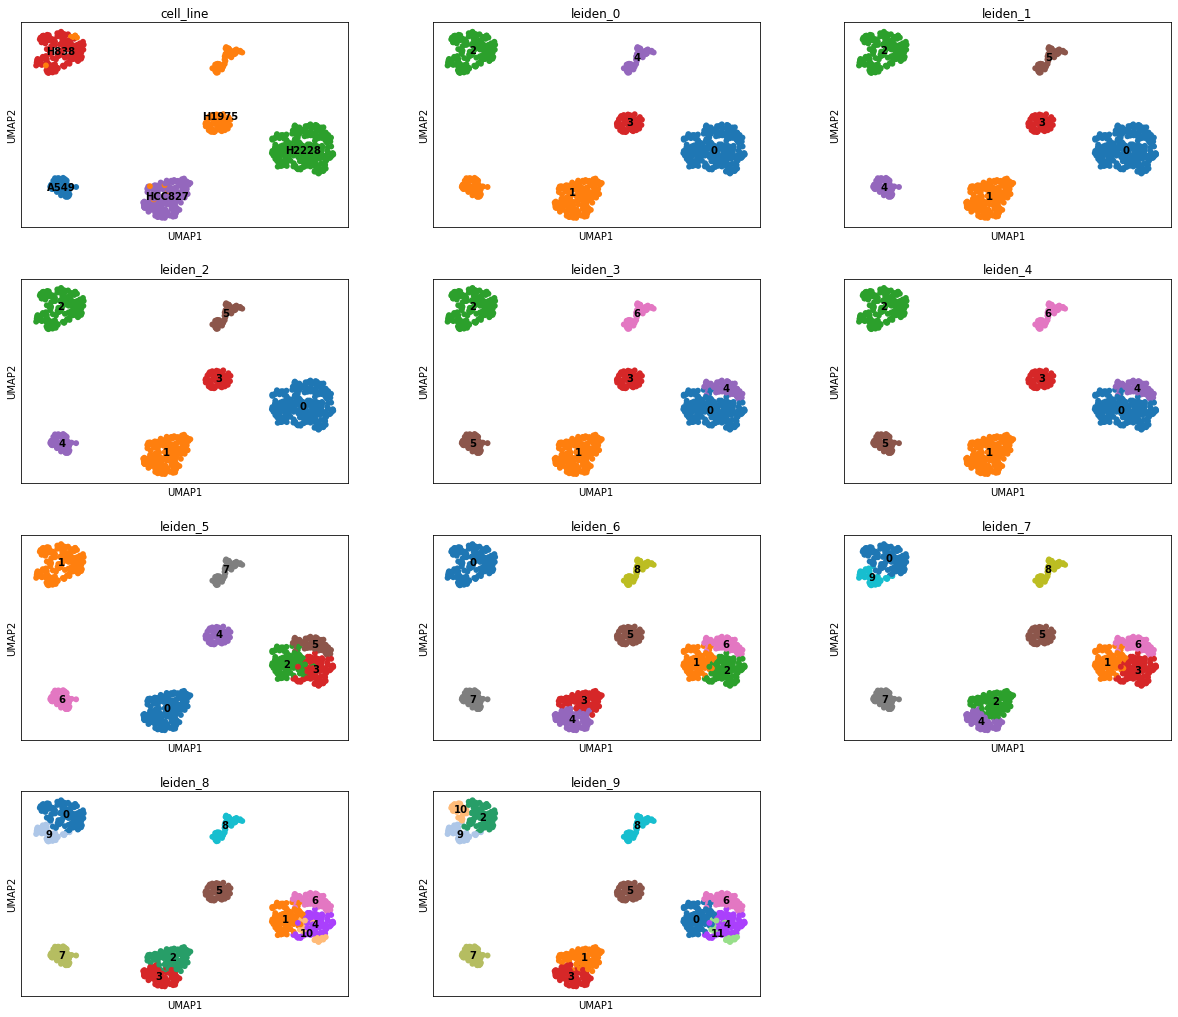

In [12]:
for l, resolution in enumerate(np.linspace(0.01, 1, 10)):
    sc.tl.leiden(adata, resolution=resolution, key_added="leiden_%d" % l)

plot_columns = ['cell_line' ] + [x for x in adata.obs_keys() if x.startswith('leiden_')]
sc.pl.umap(adata, color=plot_columns, legend_loc='on data', ncols=3)

## Nested Stochastic Block Model

Run the nested Stochastic Block Model on the same data. With default parameters, a MCMC sweep is performed with 10,000 iterations, then the chain is equilibrated. Cell marginals are not collected, nor the state is saved for debugging. The time required for the analysis is considerably longer than other approaches, consider that this notebook is being prepared on a dual-core notebook, NSBM scales well with increasing number of processors.

In [13]:
scnsbm.inference.nested_model(adata, random_seed=1024, epsilon=1e-5)

scNSBM builds a nested model with 10 levels hierarchy (by default). Note that such deepness is possibly far exceeding the required one sufficient to describe scRNA-seq experiments at default throughput (thousands of cells).
`adata.obs` slot is filled with as many levels as the ones found by the algorithm. Their names have a `nsbm_level_` prefix, followed by the level number starting from 1. We decided to not report `nsbm_level_0` as it is usually uninformative

In [14]:
print([x for x in adata.obs_keys() if x.startswith('nsbm')])

['nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6', 'nsbm_level_7', 'nsbm_level_8', 'nsbm_level_9']


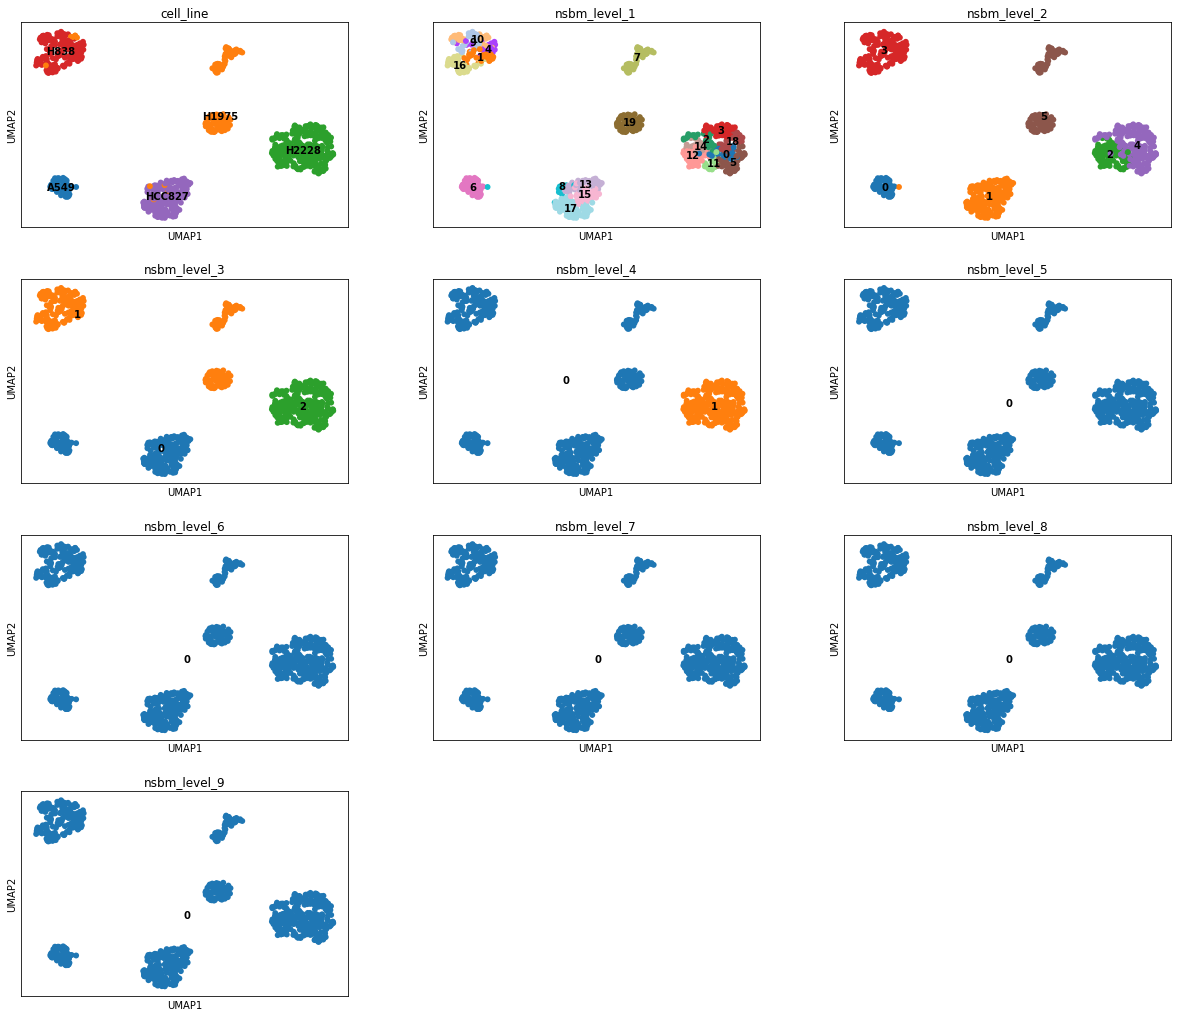

In [15]:
plot_columns = ['cell_line' ] + [x for x in adata.obs_keys() if x.startswith('nsbm_level')]
sc.pl.umap(adata, color=plot_columns, legend_loc='on data', ncols=3)


Among stats, one value is important, that is the model entropy. The contribution of each level to the total entropy is stored into `adata.uns['nsbm']['stats']['level_entropy']`. The sum of these values gives the entropy. This value can be used to compare different models obtained with different parameters. The model with lower entropy should always be chosen.

In [16]:
np.sum(adata.uns['nsbm']['stats']['level_entropy'])

18649.904821440494

In [17]:
adata.write("NSBM_demo.h5ad")

We can prune unnecessary levels, this can be automatically done by the `nested_model` function. Note that pruning only removes columns in `adata.obs` and does not affect any other information collected about the model.

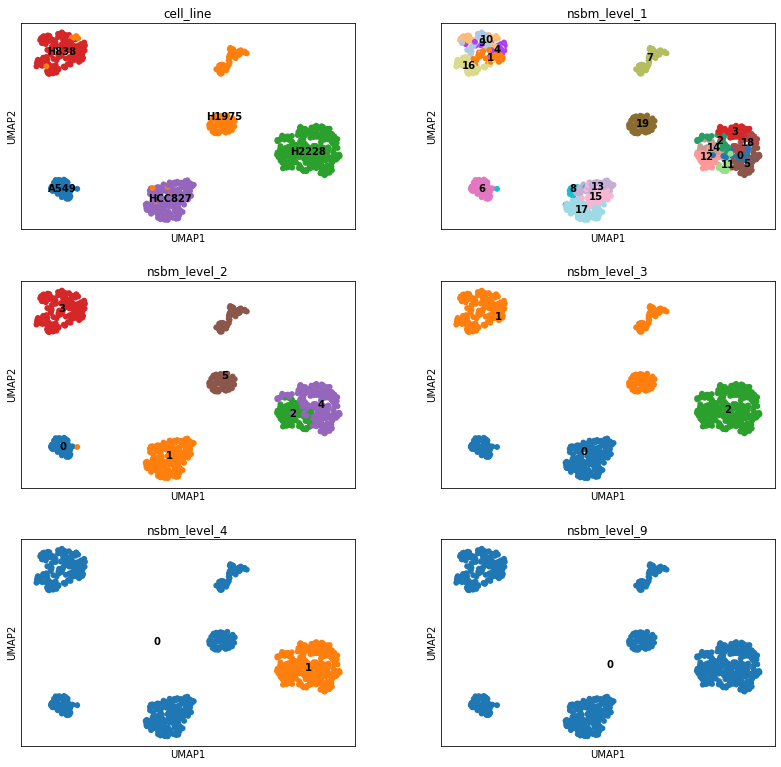

In [18]:
to_prune = scnsbm.inference.prune_groups(adata.obs.loc[:, [x for x in adata.obs_keys() if x.startswith('nsbm_level')]])
adata.obs.drop(to_prune, axis='columns', inplace=True)
plot_columns = ['cell_line' ] + [x for x in adata.obs_keys() if x.startswith('nsbm_level')]
sc.pl.umap(adata, color=plot_columns, legend_loc='on data', ncols=2)

The approach implemented by `graph_tool` minimizes the model entropy, contrary to Leiden or Louvain methods that maximize modularity. Still, modularity can be calculated for each level and for this dataset in particular, it is maximal at level 2, that is the level where all cell lines are properly separated (except for some internal heterogeneity in H2228)

Text(0, 0.5, 'Modularity')

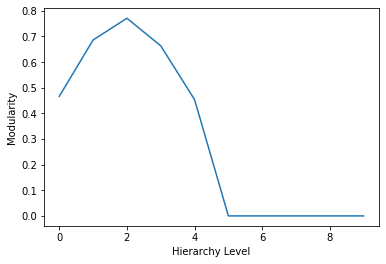

In [19]:
plot(adata.uns['nsbm']['stats']['modularity'])
xlabel("Hierarchy Level")
ylabel("Modularity")